In [2]:
#importing the libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math



In [42]:
#defining the ROI coordintes for all the 4 images
def coords(n):
    if n == 0: #for undistorted resultant image1
        return np.array([[0,0],[300,0],[300,300],[0,300]])
    
    if n == 1: #for distorted input image1
        return np.array([[142,224],[501,304],[357,633],[34,566]])
    
    if n == 2: #for undistorted resultant image2
        return np.array([[0,0],[85,0],[85,85],[0,85]])
    
    if n == 3: #for distorted input image2
        return np.array([[95,76],[202,259],[105,454],[31,269]])
    

    

In [46]:
#extra coordinates
def extracoords(n):
    if n == 1: #for distorted input image1
        return np.array([[142,224],[501,304],[357,633],[34,566],[156,354],[436,416],[372,566]])
    
    if n == 2: #for distorted input image2
        return np.array([[95,76],[202,259],[105,454],[31,269],[143,212],[171,262],[123,364]])
    

In [5]:
#drawing a box aroudnt the ROI
def box(rimg,rcord):
    rcord[:,[1,0]] = rcord[:,[0,1]]
    rcord = rcord.reshape(-1,1,2)
    cv2.polylines(rimg, pts = [rcord], isClosed = True, color =(255,0,0),thickness=1)
    plt.imshow(rimg)
    new_rimage = cv2.cvtColor(rimg,cv2.COLOR_RGB2BGR)
    cv2.imwrite("box.jpg",new_rimage)

In [6]:
#function to calculate the projective homography between two images
def proj_homography(dcord,rcord):
    A = np.zeros((8,8))
    B = np.zeros((8,1))
    H = np.ones((3,3))
    
    #Generating the matrix equation AB = C using the coordinates of the ROIs 
    for i in range(4):
        A[2*i,0] = dcord[i,0]
        A[2*i,1] = dcord[i,1]
        A[2*i,2] = 1
        A[2*i,6] = -1*dcord[i,0]*rcord[i,0]
        A[2*i,7] = -1*dcord[i,1]*rcord[i,0]
        
        A[2*i+1,3] = dcord[i,0]
        A[2*i+1,4] = dcord[i,1]
        A[2*i+1,5] = 1
        A[2*i+1,6] = -1*dcord[i,0]*rcord[i,1]
        A[2*i+1,7] = -1*dcord[i,1]*rcord[i,1]
        
        B[2*i,0] = rcord[i,0]
        B[2*i+1,0] = rcord[i,1]
        
        
    C = np.dot(np.linalg.inv(A),B);
    
    #Obtaining the Homography H
    for i in range(3):
        for j in range(3):
            if i==2 & j ==2:
                break
            H[i,j]=C[3*i +j,0]
    
    return H
            
    
    
    
        
    

In [7]:
#Creating a mask of the domain image
def masks(rimg,rcord):
    img = np.zeros_like(rimg)
    rcord[:,[1,0]] = rcord[:,[0,1]]
    rcord = rcord.reshape(-1,1,2)
    cv2.fillPoly(img, pts = [rcord], color =(255,255,255))
    for i in range(rimg.shape[0]):
        for j in range(rimg.shape[1]):
            if img[i,j,0] == 0 and img[i,j,1] == 0 and img[i,j,2] == 0:
                continue
            img[i,j] = rimg[i,j]
    return img

In [8]:
#Performing bilinear interpolation to obtain the RGB values at a floating point coordinate
def bilinear_inter(dmask,x_bar):
    
    I1 = dmask[math.floor(x_bar[0]),math.floor(x_bar[1])]
    I2 = dmask[math.floor(x_bar[0]),math.ceil(x_bar[1])]
    I3 = dmask[math.ceil(x_bar[0]),math.ceil(x_bar[1])]
    I4 = dmask[math.ceil(x_bar[0]),math.floor(x_bar[1])]
    
    return (((math.ceil(x_bar[0])-x_bar[0])*I1 + (x_bar[0]-math.floor(x_bar[0]))*I4)*(math.ceil(x_bar[1])-x_bar[1])) - (((math.ceil(x_bar[0])-x_bar[0])*I2 + (x_bar[0]-math.floor(x_bar[0]))*I3)*(math.floor(x_bar[1])-x_bar[1])) 
    
    

In [9]:
#Function to project the domain image onto the range image ROI using homography.
# Here the range coordinates are used to calculate the corresponding domain coordinates
def hom_mapping_bi(dimg,H,rcord,dmask):
    rimg = np.zeros((rcord[2,0],rcord[2,1],3),dtype=np.uint8)
    for i in range(rimg.shape[0]):
        for j in range(rimg.shape[1]):
            x  = np.array([i,j,1])
            x_bar = np.dot(H,x)
            x_bar[0] = x_bar[0]/x_bar[2]
            x_bar[1] = x_bar[1]/x_bar[2]
            i_bar = bilinear_inter(dmask,np.array([x_bar[0],x_bar[1]]))                      
            if  i_bar[0]!= 0 and i_bar[1]!= 0 and i_bar[2]!= 0 :                
                rimg[i,j] = i_bar
            
    plt.imshow(rimg)
    return rimg

In [10]:
# Here the range coordinates are used to calculate the corresponding domain coordinates
def hom_mapping_full(dimg,H):
    dcord = np.array([[0,0],[dimg.shape[0],0],[dimg.shape[0],dimg.shape[1]],[0,dimg.shape[1]]])
    ones =  np.ones((dcord.shape[0],1))
    
    hdcord = np.append(dcord,ones,1)
    rcorners = np.ones((dcord.shape[0],2))
    for k in range(dcord.shape[0]):
        temp = np.dot(np.linalg.inv(H),hdcord[k])
        temp[0] = temp[0]/temp[2]
        temp[1] = temp[1]/temp[2]
        rcorners[k] = np.array([temp[0],temp[1]])
        
    xmin = np.min(rcorners,0)[0]
    ymin = np.min(rcorners,0)[1]
    xmax = np.max(rcorners,0)[0]
    ymax = np.max(rcorners,0)[1]    
        
    rimg = np.zeros((math.floor(xmax-xmin),math.floor(ymax-ymin),3),dtype=np.uint8)
    
    #To calculate offset
    xoffset = -1*xmin
    yoffset = -1*ymin
   
    
    for i in range(rimg.shape[0]):
        for j in range(rimg.shape[1]):
            x  = np.array([i-xoffset,j-yoffset,1])
            x_bar = np.dot(H,x)
            x_bar[0] = x_bar[0]/x_bar[2]
            x_bar[1] = x_bar[1]/x_bar[2]
            
            if (x_bar[0]>0 and x_bar[1]>0 and x_bar[0]<dimg.shape[0]-1 and x_bar[1]<dimg.shape[1]-1):
                i_bar = bilinear_inter(dimg,np.array([x_bar[0],x_bar[1]]))
                rimg[i,j] = i_bar
            
    plt.imshow(rimg)
    return rimg

In [11]:
def range_image_size(dimg,H):
    dcord = np.array([[0,0],[dimg.shape[0],0],[dimg.shape[0],dimg.shape[1]],[0,dimg.shape[1]]])
    ones =  np.ones((dcord.shape[0],1))
    
    hdcord = np.append(dcord,ones,1)
    rcorners = np.ones((dcord.shape[0],2))
    for k in range(dcord.shape[0]):
        temp = np.dot(np.linalg.inv(H),hdcord[k])
        temp[0] = temp[0]/temp[2]
        temp[1] = temp[1]/temp[2]
        rcorners[k] = np.array([temp[0],temp[1]])
        
    xmin = np.min(rcorners,0)[0]
    ymin = np.min(rcorners,0)[1]
    xmax = np.max(rcorners,0)[0]
    ymax = np.max(rcorners,0)[1]    
        
    rimg = np.zeros((math.floor(xmax-xmin),math.floor(ymax-ymin),3),dtype=np.uint8)
    return rimg.shape

In [12]:
#Returns the HC of 5 pairs of orthogonal lines
def five_ortho_lines(dcord):
    
    ones =  np.ones((dcord.shape[0],1))
    hdcord = np.append(dcord,ones,1)
    l1 = np.cross(hdcord[0],hdcord[1])
    l2 = np.cross(hdcord[1],hdcord[2])
    l3 = np.cross(hdcord[2],hdcord[3])
    l4 = np.cross(hdcord[0],hdcord[3])
    l5 = np.cross(hdcord[4],hdcord[5])
    l6 = np.cross(hdcord[5],hdcord[6])
    l1 = l1/l1[2]
    l2 = l2/l2[2]
    l3 = l3/l3[2]
    l4 = l4/l4[2]
    l5 = l5/l5[2]
    l6 = l6/l6[2]
    ans = [[l1,l2],[l2,l3],[l3,l4],[l1,l4],[l5,l6]]
    return ans
    
    

In [13]:
#Returns the HC of the vanishing line
def vanishing_line(dcord):    
    ones =  np.ones((dcord.shape[0],1))
    hdcord = np.append(dcord,ones,1)
    l1 = np.cross(hdcord[0],hdcord[1])
    l2 = np.cross(hdcord[1],hdcord[2])
    l3 = np.cross(hdcord[2],hdcord[3])
    l4 = np.cross(hdcord[3],hdcord[0])
    p1 = np.cross(l1,l3)
    p2 = np.cross(l2,l4)
    vl = np.cross(p1,p2)
    return vl


In [14]:
#Function that returns H to remove purely projective distortion for two step method
def two_homography_a(dcord):
    vl = vanishing_line(dcord)
    vl = vl/vl[2]
    H = np.eye(3)
    for i in range(3):
        H[2,i] = vl[i]
    return H

In [15]:
#Function that returns H to remove purely affine distortion for two step method
def two_homography_b(dcord,H_old):
    ones =  np.ones((dcord.shape[0],1))
    hdcord = np.append(dcord,ones,1)
    new_hdcord = np.zeros_like(hdcord)
    for i in range(7):
        new_hdcord[i] = np.dot(H_old,hdcord[i])
        
    l1 = np.cross(new_hdcord[0],new_hdcord[1])
    l2 = np.cross(new_hdcord[1],new_hdcord[2])
    l3 = np.cross(new_hdcord[2],new_hdcord[3])
    l4 = np.cross(new_hdcord[3],new_hdcord[0])
    l5 = np.cross(new_hdcord[4],new_hdcord[5])
    l6 = np.cross(new_hdcord[5],new_hdcord[6])
    
    l1 = l1/l1[2]
    l2 = l2/l2[2]
    l3 = l3/l3[2]
    l4 = l4/l4[2]
    l5 = l5/l5[2]
    l6 = l6/l6[2]
    
    A = np.zeros((5,2))
    B = np.zeros((5,1))
    S = np.ones((2,2))
    H = np.zeros((3,3))
    
    A[0,0] = l1[0]*l2[0]
    A[0,1] = l1[1]*l2[0] + l1[0]*l2[1]  
    A[1,0] = l2[0]*l3[0]
    A[1,1] = l2[1]*l3[0] + l2[0]*l3[1]
    A[2,0] = l3[0]*l4[0]
    A[2,1] = l3[1]*l4[0] + l3[0]*l4[1]
    A[3,0] = l3[0]*l4[0]
    A[3,1] = l3[1]*l4[0] + l3[0]*l4[1]
    A[4,0] = l5[0]*l6[0]
    A[4,1] = l5[1]*l6[0] + l5[0]*l6[1]
    
    B[0] = -1*l1[1]*l2[1]
    B[1] = -1*l2[1]*l3[1]
    B[2] = -1*l3[1]*l4[1]
    B[3] = -1*l4[1]*l5[1]
    B[4] = -1*l5[1]*l6[1]

    
    C = np.linalg.pinv(A)@B;
    C = C/np.abs(C).max() 
    
    
    S[0,0] = C[0]
    S[0,1] = C[1]
    S[1,0] = C[1]
    
    ve,w,temp = np.linalg.svd(S)
    wpos = w
    a = ve@np.diag(np.sqrt(wpos))@np.linalg.inv(ve)
    
    H[0,0] = a[0,0]
    H[0,1] = a[0,1]
    H[1,0] = a[1,0]
    H[1,1] = a[1,1]
    H[2,2] = 1
    
    return H
    
    
    
    
        

In [36]:
#Function that returns H for one step method
def one_homography(dcord):
    ans = five_ortho_lines(dcord)
    A = np.zeros((5,5))
    B = np.zeros((5,1))
    aat = np.ones((2,2))
    av = np.ones((2,1))
    H = np.zeros((3,3))
    
    for i in range(5):
        A[i,0] = ans[i][0][0]*ans[i][1][0]
        A[i,1] = (ans[i][0][1]*ans[i][1][0] + ans[i][0][0]*ans[i][1][1])
        A[i,2] = ans[i][0][1]*ans[i][1][1]
        A[i,3] = (ans[i][0][2]*ans[i][1][0] + ans[i][0][0]*ans[i][1][2])
        A[i,4] = (ans[i][0][2]*ans[i][1][1] + ans[i][0][1]*ans[i][1][2])
        B[i,0] = -(ans[i][0][2]*ans[i][1][2])
    
    res = np.dot(np.linalg.pinv(A),B);
    res = res/np.abs(res).max()    

    aat[0,0] = res[0]
    aat[0,1] = res[1]
    aat[1,0] = res[1]
    aat[1,1] = res[2]

    av[0,0] = res[3]
    av[1,0] = res[4]

    ve,w,temp = np.linalg.svd(aat)
    wpos = w
    a = ve@np.diag(np.sqrt(wpos))@ve.T
    v = np.dot(np.linalg.pinv(a),av)

    H[0,0] = a[0,0]
    H[0,1] = a[0,1]
    H[1,0] = a[1,0]
    H[1,1] = a[1,1]
    H[2,0] = v[0]
    H[2,1] = v[1]
    H[2,2] = 1
    
    return H





    


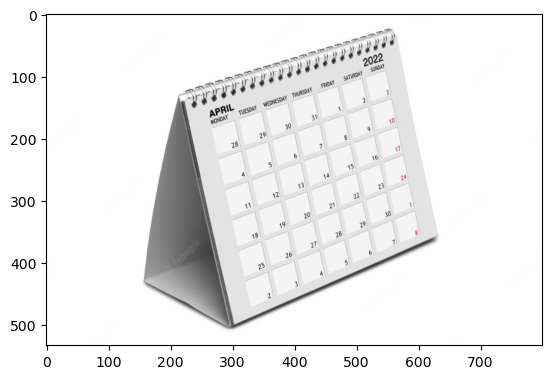

In [47]:
#Displaying the first image
dimg1 = cv2.imread ("Image1.jpg")
dimage1 = cv2.cvtColor(dimg1, cv2.COLOR_BGR2RGB)
rc1 = coords(0)
dc1 = coords(1)
dc1c = extracoords(1)
plt.imshow(dimage1)




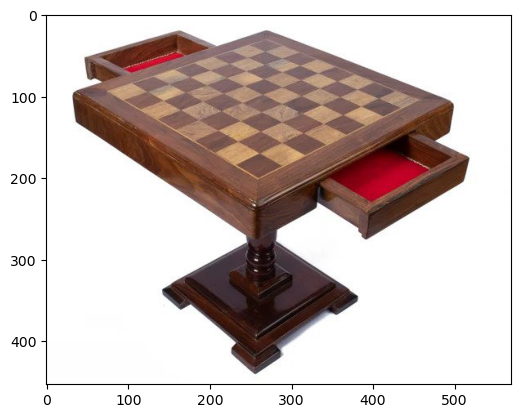

In [30]:
#Displaying the second image
dimg2 = cv2.imread ("Image3.jpg")
dimage2 = cv2.cvtColor(dimg2, cv2.COLOR_BGR2RGB)
rc2 = coords(2)
dc2 = coords(3)
dc2c = extracoords(2)
plt.imshow(dimage2)




True

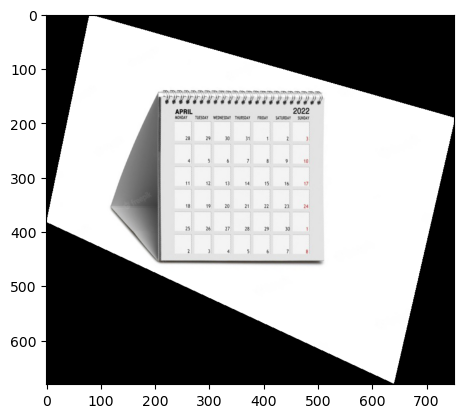

In [48]:
#Task 2a part i
H1a = proj_homography(dc1,rc1) #Calculating the homography
dmask1 = masks(dimage1,dc1)  #Creating the mask
new_rimage1a = hom_mapping_full(dimage1.copy(),np.linalg.inv(H1a)) #Generating the projection
new_rimage1a = cv2.cvtColor(new_rimage1a,cv2.COLOR_RGB2BGR)
cv2.imwrite("PTtoPT_image1.jpg",new_rimage1a)


True

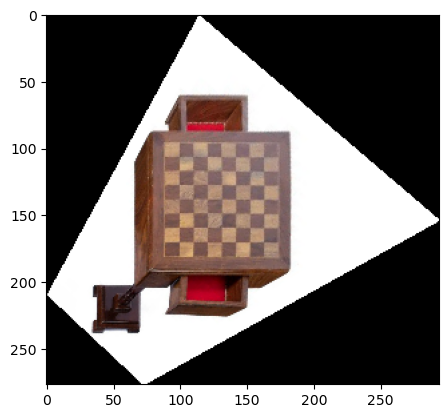

In [31]:
#Task 2a part ii
H2a = proj_homography(dc2,rc2) #Calculating the homography
dmask2 = masks(dimage2,dc2)  #Creating the mask
new_rimage2a = hom_mapping_full(dimage2.copy(),np.linalg.inv(H2a)) #Generating the projection
new_rimage2a = cv2.cvtColor(new_rimage2a,cv2.COLOR_RGB2BGR)
cv2.imwrite("PTtoPT_image2.jpg",new_rimage2a)


True

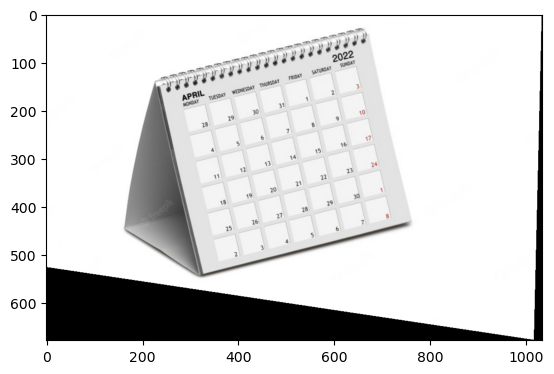

In [49]:
#Task 2b part i a
H1b = two_homography_a(dc1c) #Calculating the homography
new_rimage1b = hom_mapping_full(dimage1.copy(),np.linalg.inv(H1b)) #Generating the projection
new_rimage1b = cv2.cvtColor(new_rimage1b,cv2.COLOR_RGB2BGR)
cv2.imwrite("twoa_image1.jpg",new_rimage1b)

True

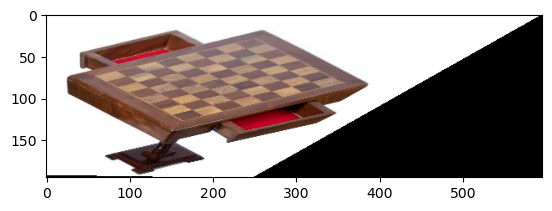

In [32]:
#Task 2b part i b

H2b = two_homography_a(dc2c) #Calculating the homography
new_rimage2b = hom_mapping_full(dimage2.copy(),np.linalg.inv(H2b)) #Generating the projection
new_rimage2b = cv2.cvtColor(new_rimage2b,cv2.COLOR_RGB2BGR)
cv2.imwrite("twoa_image2.jpg",new_rimage2b)

True

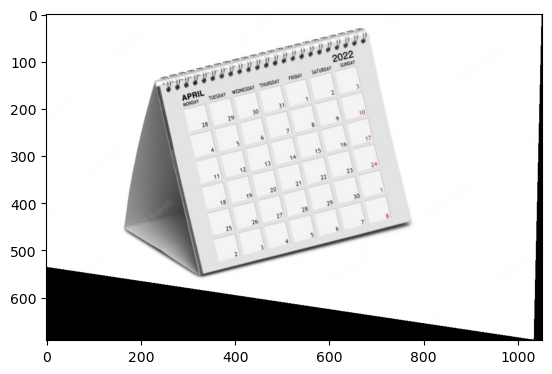

In [50]:
#Task 2b part ii a
H1bb = two_homography_b(dc1c,H1b) 
new_rimage1bb = hom_mapping_full(dimage1.copy(),np.linalg.inv(H1bb@H1b)) #Generating the projection
new_rimage1bb = cv2.cvtColor(new_rimage1bb,cv2.COLOR_RGB2BGR)
cv2.imwrite("twob_image1.jpg",new_rimage1bb)



True

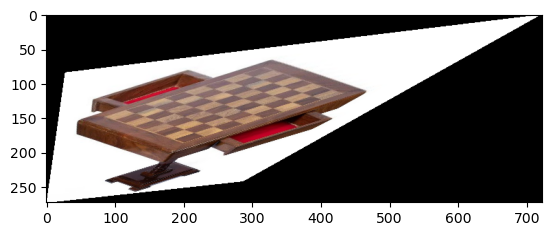

In [33]:
#Task 2b part ii b
H2bb = two_homography_b(dc2c,H2b) 
new_rimage2bb = hom_mapping_full(dimage2.copy(),np.linalg.inv(H2bb@H2b)) #Generating the projection
new_rimage2bb = cv2.cvtColor(new_rimage2bb,cv2.COLOR_RGB2BGR)
cv2.imwrite("twob_image2.jpg",new_rimage2bb)

True

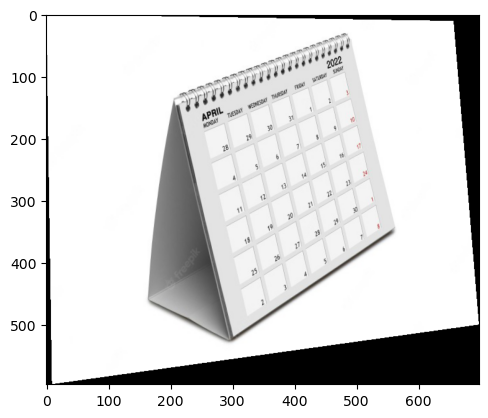

In [51]:
#Task 2c part i
H1c = one_homography(dc1c) #Calculating the homography
new_rimage1 = hom_mapping_full(dimage1.copy(),np.linalg.pinv(H1c)) #Generating the projection
new_rimage1 = cv2.cvtColor(new_rimage1,cv2.COLOR_RGB2BGR)
cv2.imwrite("one_image1.jpg",new_rimage1)

True

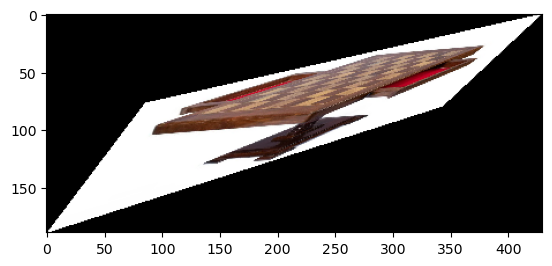

In [41]:
#Task 2c part ii
H2c = one_homography(dc2c) #Calculating the homography
new_rimage2 = hom_mapping_full(dimage2.copy(),np.linalg.pinv(H2c)) #Generating the projection
new_rimage2 = cv2.cvtColor(new_rimage2,cv2.COLOR_RGB2BGR)
cv2.imwrite("one_image2.jpg",new_rimage2)